In [1]:
%cd ..

/home/wiss/hofherrf/gitRepos/pendulum_2d


In [2]:
import os
import torch
import yaml
from models.sceneRepresentation import Scene
from dataset.dataset import DynamicPixelDataset
import matplotlib.pyplot as plt
from torchvision import utils
from util.util import compute_psnr, compute_iou

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [4]:
path_experiments = os.path.join(
    os.path.abspath(''),
    'experiments',
    '2023-01-24',
    'synthetic',
    'posed',
    'stonewall'
)

psnrs = []
ious = []
path_file = os.path.join(path_experiments, 'results.txt')

# Delete previous result files
if os.path.exists(path_file):
    os.remove(path_file)

# Get all the experiments
for path_experiment in os.scandir(path_experiments):
    # Load Config
    path_conf = os.path.join(path_experiment, '.hydra','config.yaml')
    with open(path_conf) as f:
        cfg = yaml.safe_load(f)

    print("Doing: ", cfg['data']['path_data'])

    # Load Model
    model = Scene(**cfg['scene']['background'])
    model.add_posedLocal(
        t_poses=torch.zeros(cfg['data']['max_samples']),
         **cfg['scene']['local_representation']
    )

    path_ckpt = os.path.join(path_experiment, 'ckpt.pth')
    model.load_state_dict(torch.load(path_ckpt))

    model.to(device)

    # Load Data
    path_data = os.path.join(os.path.abspath(''), 'data',cfg['data']['path_data'])
    data = DynamicPixelDataset(
        path_data,
        skip_timesteps=cfg['data']['skip_timesteps'],
        start_index=cfg['data']['start_idx_test'],
        max_samples=cfg['data']['max_samples_eval']
    )
    H, W = data.get_image_dim()

    # Compute PSNR and IoU
    tspan = data.parameters["tspan"].to(device)
    model.update_trafo(tspan)
    output = model.render_image(W, H)
    psnr = compute_psnr(output['Image'].cpu(), data.get_full_images())
    iou = compute_iou(output['Mask'].cpu(), data.get_full_mask())
    psnrs.append(psnr)
    ious.append(iou)

    # Write summary file
    with open(path_file, 'a') as f:
        f.write(f"{cfg['data']['path_data']}\n")
        f.write(f"{path_experiment.path}\n")
        f.write(f"PSNR: {psnr}\n")
        f.write(f"IoU: {iou}\n")
        f.write("=============================\n\n")

    print(f"PSNR: {psnr}, IoU: {iou}")

    print("Done")
    print("====================================================")

avg_psnr = torch.mean(torch.tensor(psnrs))
avg_iou = torch.mean(torch.tensor(ious))
print("Results:")
print(f"Avg PSNR: {avg_psnr}, Avg IoU: {avg_iou}")

# Write to results file
with open(path_file, 'a') as f:
    f.write("\nLatex\n")
    f.write(f"{avg_psnr:.2f} & {avg_iou:.2f} & -")

Doing:  synthetic_data/stonewall9
PSNR: 31.938434600830078, IoU: 0.936050534248352
Done
Doing:  synthetic_data/stonewall1
PSNR: 28.72150230407715, IoU: 0.789380669593811
Done
Doing:  synthetic_data/stonewall6
PSNR: 33.895912170410156, IoU: 0.9176668524742126
Done
Doing:  synthetic_data/stonewall4
PSNR: 34.319061279296875, IoU: 0.9239649772644043
Done
Doing:  synthetic_data/stonewall3
PSNR: 28.373126983642578, IoU: 0.7328119874000549
Done
Doing:  synthetic_data/stonewall5
PSNR: 34.17036819458008, IoU: 0.9289168119430542
Done
Doing:  synthetic_data/stonewall7
PSNR: 30.605613708496094, IoU: 0.8997849225997925
Done
Doing:  synthetic_data/stonewall2
PSNR: 29.329551696777344, IoU: 0.7933859825134277
Done
Doing:  synthetic_data/stonewall8
PSNR: 35.22838592529297, IoU: 0.980451226234436
Done
Results:
Avg PSNR: 31.84244155883789, Avg IoU: 0.8780460357666016


In [5]:
path_experiment = os.path.join(
    os.path.abspath(''),
    'experiments',
    '2023-01-24',
    'synthetic',
    'posed',
    'stonewall',
    '18-01-13_seq1'
)

path_folder = os.path.join(path_experiment, 'renderings')
if not os.path.isdir(path_folder):
    os.makedirs(path_folder)

# Load Config
path_conf = os.path.join(path_experiment, '.hydra','config.yaml')
with open(path_conf) as f:
    cfg = yaml.safe_load(f)

# Load Model
model = Scene(**cfg['scene']['background'])
model.add_posedLocal(
    t_poses=torch.zeros(cfg['data']['max_samples']),
        **cfg['scene']['local_representation']
)

path_ckpt = os.path.join(path_experiment, 'ckpt.pth')
model.load_state_dict(torch.load(path_ckpt))

model.to(device)
print("Model loaded")

Model loaded


Data loaded
tensor([0.0000, 0.2020, 0.4040, 0.6061, 0.8081, 1.0101, 1.2121, 1.4141, 1.6162,
        1.8182, 2.0202, 2.2222, 2.4242, 2.6263, 2.8283, 3.0303, 3.2323, 3.4343,
        3.6364, 3.8384, 4.0404, 4.2424, 4.4444, 4.6465, 4.8485],
       device='cuda:0')


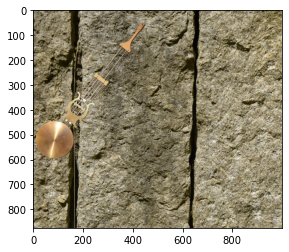

In [6]:
# Train images
# Load Data
path_data = os.path.join(os.path.abspath(''), 'data',cfg['data']['path_data'])
data = DynamicPixelDataset(
    path_data,
    skip_timesteps=cfg['data']['skip_timesteps'],
    max_samples=cfg['data']['max_samples']
)
H, W = data.get_image_dim()
print("Data loaded")

# Render
tspan = data.parameters["tspan"].to(device)
print(tspan)
model.update_trafo(tspan)
output = model.render_image(W, H)
ims = output["Image"].cpu()
masks = output['Mask'].cpu()

plt.imshow(ims[0])